<a href="https://colab.research.google.com/github/CristylePGarrard/ElectionTime/blob/main/exec_branch_kpi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pull in Data

In [1]:
# ####### Install necessary libraries ####### #
!pip install gspread gspread-dataframe pandas openpyxl

# ####### Import libraries ####### #
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from googleapiclient.discovery import build

In [2]:
# ################################################### #
# ####### pull in the data for the candidates ####### #
# ################################################### #

# ####### Mount Google Drive to Colab ####### #
from google.colab import drive
drive.mount('/content/drive')

# ####### Set the file path to uploaded Excel file ####### #
# Update the path with the actual location of file in Google Drive
file_path = '/content/drive/My Drive/ut_pol/'
filename = 'cleaned_candidates_data.csv'

# ####### Read the Excel file into a DataFrame ####### #
print("Reading Excel file...")

# There's a weird warning about the format and openpyxl but we don't gotta worry about that so ignore it
import warnings
warnings.simplefilter("ignore")

# Read the Excel file
candidates = pd.read_csv(file_path+filename)

# don't need all the info right now
include_columns = ['Name on Ballot', 'First Name', 'Middle Name',
                   'Last Name', 'Office', 'District', 'Party',
                   'Status','Display District', 'record_id', 'Incumbent']
candidates = candidates[include_columns].copy()

# only need candidates that are running again
include_status = ['Election Candidate', 'Write-In']
candidates = candidates.loc[candidates['Status'].isin(include_status)].copy().reset_index(drop=True)

# only look at incumbent candidates
candidates = candidates.loc[candidates['Incumbent'] == True].copy().reset_index(drop=True)
# only look at State House & State Senate
candidates = candidates.loc[candidates['Office'].isin(['State House', 'State Senate'])].copy().reset_index(drop=True)

# check data
print(candidates.info())
# print(candidates.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading Excel file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name on Ballot    65 non-null     object
 1   First Name        65 non-null     object
 2   Middle Name       33 non-null     object
 3   Last Name         65 non-null     object
 4   Office            65 non-null     object
 5   District          65 non-null     object
 6   Party             65 non-null     object
 7   Status            65 non-null     object
 8   Display District  65 non-null     object
 9   record_id         65 non-null     object
 10  Incumbent         65 non-null     bool  
dtypes: bool(1), object(10)
memory usage: 5.3+ KB
None


In [3]:
# #################################################################### #
# ####### pull in the data for the bills that have been passed ####### #
# #################################################################### #

import os

bills_file_path = '/content/drive/My Drive/ut_pol/passedBills/'

list_of_bills = os.listdir(bills_file_path)
# print(list_of_bills)

all_data = []

for f in list_of_bills:
  if f.endswith('.csv'):
    temp = pd.read_csv(bills_file_path + f)
    temp['sheet_name'] = f
    all_data.append(temp)

bills = pd.concat(all_data, axis=0, ignore_index=True)

print(bills.info())

# we only need data for 2021 - 2024
bills['Year'] = bills['sheet_name'].str.extract(r'(\d{4})')
bills = bills.loc[bills['Year'].isin(['2021', '2022', '2023', '2024'])].copy().reset_index(drop=True)

# make sure dtypes are correct
bills['Date Passed'] = pd.to_datetime(bills['Date Passed'], errors='coerce')
bills['Effective Date'] = pd.to_datetime(bills['Effective Date'], errors='coerce')
bills['Gov\'s Action Date'] = pd.to_datetime(bills['Gov\'s Action Date'], errors='coerce')
bills['Year'] = bills['Year'].astype(int)

# What to do when the gov's action is empty

bills['Governor\'s Action'].unique()

bills.loc[bills['Governor\'s Action'].isnull()]

# Replace null values in the 'Governor's Action' column with 'no value'
bills['Governor\'s Action'] = bills['Governor\'s Action'].fillna('NO VALUE').copy().reset_index(drop=True)

# Check the updated 'Governor's Action' column
bills['Governor\'s Action'].unique()

print("\nNumber of bills: ", len(bills))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811 entries, 0 to 2810
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bill Number           2811 non-null   object 
 1   Bill Title            2811 non-null   object 
 2   Bill Sponsor          2811 non-null   object 
 3   Date Passed           2811 non-null   object 
 4   Effective Date        1182 non-null   object 
 5   Governor's Action     2672 non-null   object 
 6   Gov's Action Date     2672 non-null   object 
 7   Laws of Utah Chapter  2544 non-null   float64
 8   sheet_name            2811 non-null   object 
dtypes: float64(1), object(8)
memory usage: 197.8+ KB
None

Number of bills:  2232


In [4]:
# Check a few records to make sure data is correct

print(bills.loc[bills['Bill Number'] == 'HB0007']['Bill Title'])

print(bills.loc[22][['Bill Title', 'Bill Sponsor', 'Date Passed']])

print(bills.loc[1144][['Bill Title', 'Bill Sponsor', 'Date Passed']])

print(bills.loc[1646][['Bill Title', 'Bill Sponsor', 'Date Passed']])

22      National Guard, Veterans Affairs, and Legislat...
1144    National Guard, Veterans Affairs, and Legislat...
1646                         Social Services Base Budget 
Name: Bill Title, dtype: object
Bill Title      National Guard, Veterans Affairs, and Legislat...
Bill Sponsor                                         Peterson, V.
Date Passed                                   2023-01-26 00:00:00
Name: 22, dtype: object
Bill Title      National Guard, Veterans Affairs, and Legislat...
Bill Sponsor                                             Last, B.
Date Passed                                   2021-01-28 00:00:00
Name: 1144, dtype: object
Bill Title      Social Services Base Budget 
Bill Sponsor                        Ward, R.
Date Passed              2024-01-25 00:00:00
Name: 1646, dtype: object


# Governor

In [5]:
# import libraries
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from collections import defaultdict, Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


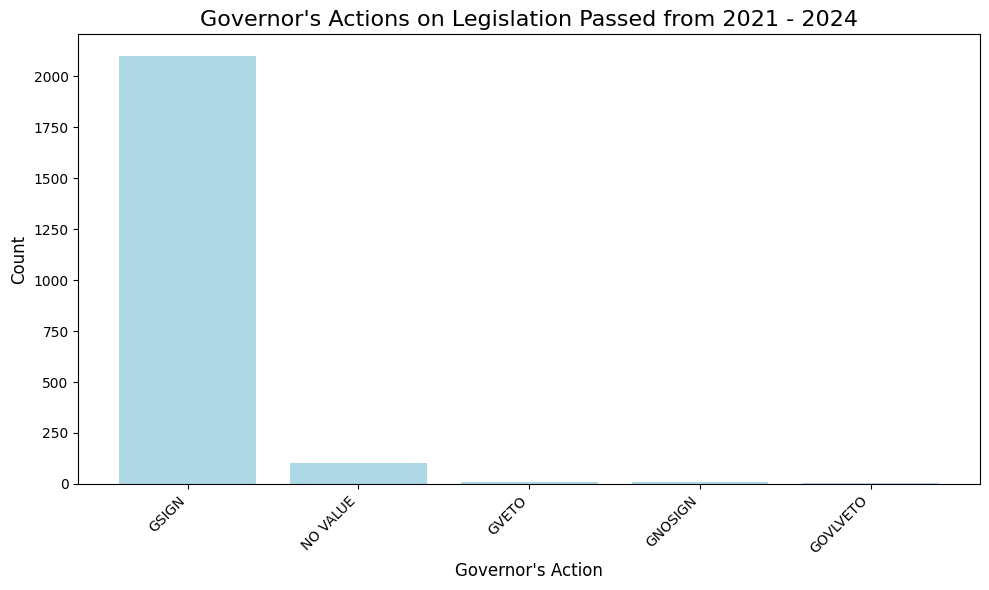

Governor's Action  Count
            GSIGN   2100
         NO VALUE    105
            GVETO     12
          GNOSIGN      8
         GOVLVETO      7


In [22]:
# ############################################################################################ #
# ####### What does the goveneror do when the bills are passed? ############################## #
# ####### ** 9 Oct 2024 ** matplotlib will display the charts in github vs plotly that doesn't #
# ############################################################################################ #

import pandas as pd
import matplotlib.pyplot as plt

# Count the governor's actions
gov_action_counts = bills['Governor\'s Action'].value_counts().reset_index()
gov_action_counts.columns = ['Governor\'s Action', 'Count']

# Create a bar chart for governor's actions
plt.figure(figsize=(10, 6))
plt.bar(gov_action_counts['Governor\'s Action'], gov_action_counts['Count'], color='lightblue')
plt.title("Governor's Actions on Legislation Passed from 2021 - 2024", fontsize=16)
plt.xlabel('Governor\'s Action', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the table using pandas
gov_action_table = gov_action_counts
print(gov_action_table.to_string(index=False))

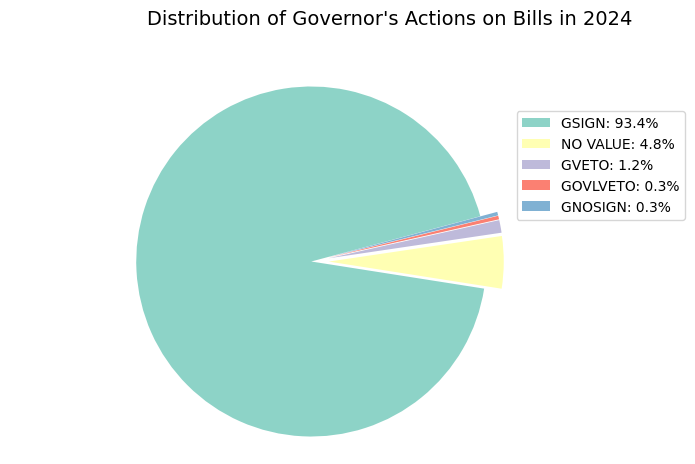

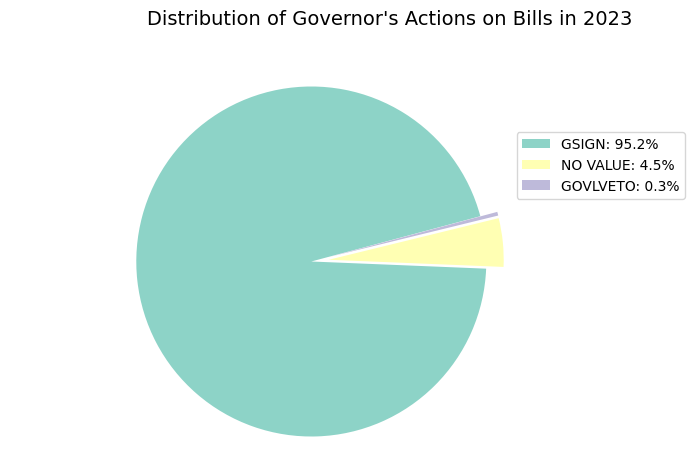

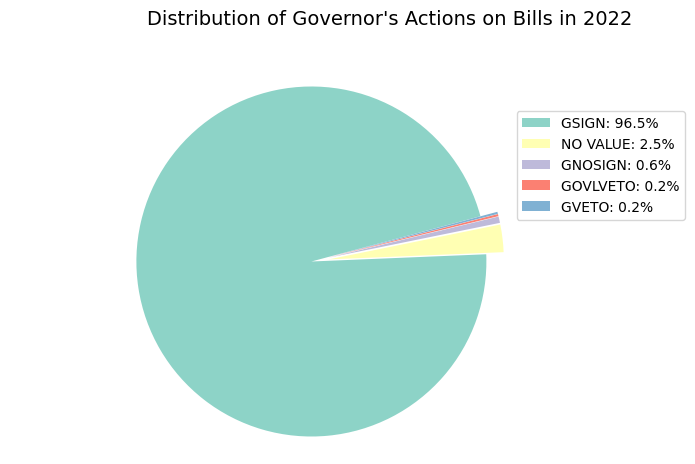

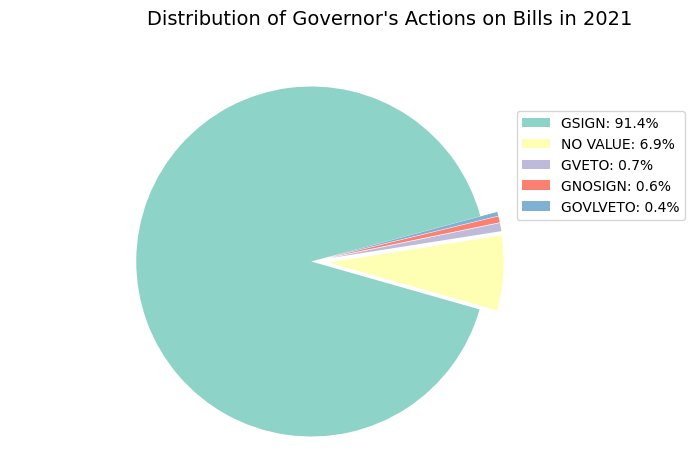

In [101]:
# ######################################################################## #
# ####### Does he do the same thing each year? ########################### #
# ** 9 October 2024 ** Switched charts to use matplotlib instead of plotly #
# ######################################################################## #

mport numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming bills dataframe has a 'Year' column already
unique_years = bills['Year'].unique()

# Define a threshold for what you consider a "small" slice
small_slice_threshold = 10  # Percent threshold for small slices

# Loop through each year to create pie charts for Governor's Actions
for year in unique_years:

    # Filter bills by year
    bills_year = bills[bills['Year'] == year]

    # Group by 'Governor's Action' and count the number of bills for each action
    gov_actions_count = bills_year['Governor\'s Action'].value_counts().reset_index()
    gov_actions_count.columns = ['Governor\'s Action', 'Count']

    # Calculate percentages to identify small slices
    total_bills = gov_actions_count['Count'].sum()
    percentages = (gov_actions_count['Count'] / total_bills) * 100

    # Determine which slices to explode (i.e., pull out)
    explode = [0.1 if pct < small_slice_threshold else 0 for pct in percentages]

    # Create pie chart using matplotlib
    fig, ax = plt.subplots(figsize=(8, 5))

    # Pie chart without labels (just the slices)
    wedges, texts = ax.pie(
        gov_actions_count['Count'],
        startangle=15,  # Start angle adjusted as requested
        explode=explode,
        colors=plt.cm.Set3.colors
    )

    # Add a legend using a table format
    # Create the table data with colors, labels, and percentages
    legend_data = []
    for i, (wedge, percentage) in enumerate(zip(wedges, percentages)):
        color = wedge.get_facecolor()  # Get the color of each slice
        label = gov_actions_count['Governor\'s Action'][i]  # Get action name
        percentage_value = f"{percentage:.1f}%"  # Format the percentage

        # Append each row to the legend data
        legend_data.append([plt.Rectangle((0, 0), 1, 1, fc=color), label, percentage_value])

    # Create the table (as a legend) next to the pie chart
    plt.legend(handles=[entry[0] for entry in legend_data],
               labels=[f'{entry[1]}: {entry[2]}' for entry in legend_data],
               loc='center right', bbox_to_anchor=(1.1, 0.75), fontsize=10)

    # Center the title above both the pie chart and the legend
    # Center the title above both the pie chart and the legend with reduced padding
    plt.suptitle(f"Distribution of Governor's Actions on Bills in {year}", fontsize=14, y=1, x=.6)

    # Make sure the chart and legend fit within the figure
    plt.tight_layout(rect=[1, 1, 1, 0.95])  # Adjust layout to make room for the title and legend
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Display the chart
    plt.show()


In [8]:
# ######################################################## #
# ####### What are the bills that he doesn't sign? ####### #
# ######################################################## #

# bills that do not have 'GSIGN'
filtered_bills = bills[bills['Governor\'s Action'] != 'GSIGN']

grouped_bills = filtered_bills.groupby('Governor\'s Action')

# list of tables for each Governor's Action
figures = []

for action, group in grouped_bills:

    action_bills = group[['Bill Number', 'Bill Title', 'Bill Sponsor', 'Date Passed']].sort_values(by='Date Passed')
    action_bills['Date Passed'] = action_bills['Date Passed'].dt.strftime('%m/%d/%Y')

    fig = go.Figure(data=[go.Table(
        header=dict(values=["Bill Number", "Bill Title", "Bill Sponsor", "Date Passed"],
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[action_bills[col] for col in ['Bill Number', 'Bill Title', 'Bill Sponsor', 'Date Passed']],
                   fill_color='lavender',
                   align='left'))
    ])

    fig.update_layout(
        title_text=f"Legislation where Governor's Action is '{action}' from 2021 - 2024",
        title_x=0.5,  # center title
        title_font=dict(size=18, family='Arial'),
        margin=dict(l=50, r=50, t=75, b=10),  # Adjust margins to tighten the layout
        height=600  # Set a fixed height for the table
    )

    figures.append(fig)

for fig in figures:
    fig.show()


In [9]:
# ###################################################### #
# ####### Let's look at a timeline for the bills ####### #
# is there any kind of trend to when the goverenor signs #
# them or what his actions are on the bills? ########### #
# ###################################################### #

# filter rows where 'Date Passed' is NaT
bills_cleaned = bills.dropna(subset=['Date Passed'])

# count the number of bills per action
bill_counts = bills_cleaned.groupby(['Governor\'s Action', 'Date Passed']).size().reset_index(name='Count')

# color map
color_map = {
    'GSIGN': '#2ca02c',  # Green
    'GOVLVETO': '#ff7f0e',  # Orange
    'NO VALUE': '#1f77b4',   # Blue
    'GVETO': '#d62728', # Red
    'GNOSIGN': '#9467bd', # Purple
}

# line plot
fig = px.line(
    bill_counts,
    x='Date Passed',
    y='Count',
    color='Governor\'s Action',
    title='Timeline of Bills Passed with Different Governor Actions',
    labels={'Date Passed': 'Date', 'Count': 'Number of Bills'},
    color_discrete_map=color_map  # Apply the consistent color map
)

fig.update_layout(
    xaxis_title='Date Passed',
    yaxis_title='Number of Bills',
    legend_title='Governor\'s Action',
    hovermode='x unified',  # Shows date information in hover
    title_x=0.5,  # Center the title
    title_font=dict(size=18, family='Arial'),
    margin=dict(l=50, r=50, t=75, b=50)
)

fig.show()


In [10]:
# ################################################################## #
# ####### What if we break it up into 4 charts instead of 1? ####### #
# ################################################################## #

# Add 'Year' column
bills['Year'] = bills['Date Passed'].dt.year

# color map
color_map = {
    'GSIGN': '#2ca02c',  # Green
    'GOVLVETO': '#ff7f0e',  # Orange
    'NO VALUE': '#1f77b4',   # Blue
    'GVETO': '#d62728', # Red
    'GNOSIGN': '#9467bd', # Purple
}

# Create a list of years and an empty list to store figures
years = [2021, 2022, 2023, 2024]
figures = []

for year in years:

    bills_year = bills[bills['Year'] == year].dropna(subset=['Date Passed'])

    bill_counts_year = bills_year.groupby(['Governor\'s Action', 'Date Passed']).size().reset_index(name='Count')

    fig = px.line(
        bill_counts_year,
        x='Date Passed',
        y='Count',
        color='Governor\'s Action',
        title=f'Timeline of Bills Passed with Different Governor Actions in {year}',
        labels={'Date Passed': 'Date', 'Count': 'Number of Bills'},
        color_discrete_map=color_map  # Apply the consistent color map
    )

    fig.update_layout(
        xaxis_title='Date Passed',
        yaxis_title='Number of Bills',
        legend_title='Governor\'s Action',
        hovermode='x unified',  # Shows date information in hover
        title_x=0.5,  # Center the title
        title_font=dict(size=18, family='Arial'),
        margin=dict(l=50, r=50, t=75, b=50)
    )

    figures.append(fig)

for fig in figures:
    fig.show()

In [11]:
# key words, categories of stuff
# education, trans rights,

# dictionary of categories with relevant keywords
categories = {
    'Education': ['education', 'school', 'university', 'student',
                  'higher', 'juvenile', 'extension'],
    'Healthcare': ['health', 'medical', 'hospital', 'care'],
    'Environment': ['environment', 'wildlife', 'conservation', 'climate',
                    'public lands', 'water', 'land', 'energy', 'safety'],
    'Infrastructure': ['road', 'bridge', 'infrastructure', 'transport'],
    'Tax': ['tax', 'income', 'revenue', 'finance'],
    'Government & Law': ['government', 'law', 'amendment', 'resolution', 'amendments',
                         'commission', 'committee', 'criminal', 'justice', 'protection',
                         'court', 'government', 'local', 'authority'],
    'Health & Social Services': ["mental", "child", "public", "services", "emergency", "insurance"],
    'Transportation & Vehicles': ["vehicle", "access", "use", "transportation"],
    'Budget & Finance': ["budget", "fund", "appropriations", "funding"],
    'Licensing & Rules': ["rules", "requirements", "licensing", "license", "code"],
    'Miscellaneous': ["revisions", "modifications", "sunset", "advisory"]
}

# categorize bill titles based on keywords
def categorize_bills(title, categories):
    title = title.lower()  # Convert to lowercase
    for category, keywords in categories.items():
        if any(keyword in title for keyword in keywords):
            return category
    return 'Other'  # If no keyword matches, classify as 'Other'

bills['Category'] = bills['Bill Title'].apply(lambda x: categorize_bills(x, categories))

# count bills in each category
category_counts = bills['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

fig = px.bar(
    category_counts,
    x='Category',
    y='Count',
    title="Breakdown of Bills by Category",
    labels={'Count': 'Number of Bills'},
    color='Category'
)

fig.show()

In [12]:
# words that should be ignored like the, and, etc
stop_words = set(stopwords.words('english'))

# other words to ignore
extra_stop_words = {'bill', 'act', 'law', 'amendment', 'resolution',
                    'amendments', 'education', 'school', 'university',
                    'student', 'health', 'medical', 'hospital', 'care',
                   'environment', 'wildlife', 'conservation', 'climate',
                   'public lands', 'road', 'bridge', 'infrastructure',
                   'transport', 'tax', 'income', 'revenue', 'finance'}
stop_words.update(extra_stop_words)

# Function to clean and tokenize bill titles
def tokenize_title(title):
    title = title.lower()  # Convert to lowercase
    tokens = title.split()  # Split title into words
    tokens = [word.strip(string.punctuation) for word in tokens]  # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

bills['Tokens'] = bills['Bill Title'].apply(tokenize_title)

all_tokens = [token for sublist in bills['Tokens'] for token in sublist]
word_counts = Counter(all_tokens)

# most common words
common_words = word_counts.most_common(50)  # Adjust the number to get more/less words

for word, count in common_words:
    print(f"{word}: {count}")

modifications: 140
state: 121
utah: 92
concurrent: 83
public: 82
program: 80
joint: 78
revisions: 74
requirements: 70
services: 70
water: 51
rules: 48
property: 47
: 46
vehicle: 42
commission: 40
child: 40
government: 38
budget: 38
criminal: 36
sunset: 34
local: 34
base: 32
use: 32
licensing: 31
higher: 30
extension: 30
justice: 29
funding: 28
development: 27
mental: 27
juvenile: 27
fund: 27
protection: 27
energy: 26
land: 26
appropriations: 24
insurance: 24
board: 24
license: 24
code: 23
committee: 23
authority: 23
safety: 23
management: 22
county: 22
court: 21
emergency: 21
advisory: 21
access: 21


In [13]:
categories = {
    'Education': ['higher education', 'juvenile', 'school', 'university', 'student', 'education', 'students', 'teacher', 'educator'],
    'Healthcare': ['health', 'medical', 'hospital', 'healthcare'],
    'Environment': ['wildlife', 'conservation', 'climate', 'public lands', 'water', 'land', 'energy', 'federal lands', 'national parks', 'parks'],
    'Health & Social Services': ['mental health', 'public health', 'health', 'services', 'insurance'],
    'Transportation & Vehicles': ['vehicle', 'access', 'use', 'road', 'bridge', 'infrastructure', 'transport', 'transportation'],
    'Veteran Services': ['veteran', 'national guard', 'veterans'],
    'Government & Law': ['commission', 'criminal', 'justice', 'protection', 'court', 'government', 'authority', 'advisory', 'ammendment', 'resolution'],
    'Tax': ['tax', 'income', 'revenue', 'finance'],
    'Budget & Finance': ['budget', 'fund', 'appropriations'],
    'Licensing & Rules': ['rules', 'requirements', 'licensing', 'code'],
}

def categorize_bill(title):
    title = title.lower()  # convert title to lowercase for easier matching
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in title:
                return category
    return 'Other'  # If no category matches, return 'Other'

bills['Category'] = bills['Bill Title'].apply(categorize_bill)

print(bills[['Bill Title', 'Category']].head())

                                  Bill Title           Category
0  Exchange Student Guardianship Amendments           Education
1           Public Lands Funding Amendments         Environment
2                School District Amendments           Education
3               Energy Security Adjustments         Environment
4   Sunset and Repeal Date Code Corrections   Licensing & Rules


In [14]:
# count the number of bills in each category
category_counts = bills['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# pie chart
fig_pie = px.pie(category_counts, values='Count', names='Category',
                 title='Distribution of Bills by Category')

fig_pie.show()

In [15]:
# bar chart
fig_bar = px.bar(category_counts, x='Category', y='Count',
                 title='Number of Bills by Category',
                 labels={'Count': 'Number of Bills'},
                 color='Category')

fig_bar.show()

In [16]:
# treemap
fig_treemap = px.treemap(category_counts, path=['Category'], values='Count',
                         title='Treemap of Bills by Category')

fig_treemap.show()

In [17]:
bills.loc[bills['Bill Number'] == 'HB0007']

,Bill Number,Bill Title,Bill Sponsor,Date Passed,Effective Date,Governor's Action,Gov's Action Date,Laws of Utah Chapter,sheet_name,Year,Category,Tokens
22,HB0007,"National Guard, Veterans Affairs, and Legislat...","Peterson, V.",2023-01-26,2023-05-03,GSIGN,2023-02-02,6.0,passedBills_2023_general_session.csv,2023,Veteran Services,"[national, guard, veterans, affairs, legislatu..."
1144,HB0007,"National Guard, Veterans Affairs, and Legislat...","Last, B.",2021-01-28,NaT,GSIGN,2021-02-04,4.0,passedBills_2021_general_session.csv,2021,Veteran Services,"[national, guard, veterans, affairs, legislatu..."
1646,HB0007,Social Services Base Budget,"Ward, R.",2024-01-25,2024-07-01,GSIGN,2024-01-31,10.0,passedBills_2024_general_session.csv,2024,Health & Social Services,"[social, services, base, budget]"


In [18]:
bills.loc[bills['Category'] == 'Budget & Finance'][['Bill Number', 'Bill Title', 'Bill Sponsor', 'Date Passed', 'Category', 'Governor\'s Action', 'Tokens']]

,Bill Number,Bill Title,Bill Sponsor,Date Passed,Category,Governor's Action,Tokens
13,HB1001,Emergency Response Funding,"Peterson, V.",2023-05-17,Budget & Finance,GSIGN,"[emergency, response, funding]"
19,HB0003,Current Fiscal Year Supplemental Appropriations,"Peterson, V.",2023-03-01,Budget & Finance,GSIGN,"[current, fiscal, year, supplemental, appropri..."
20,HB0004,"Business, Economic Development, and Labor Base...","Watkins, C.",2023-01-26,Budget & Finance,GSIGN,"[business, economic, development, labor, base,..."
96,HB0110,Waste Tire Recycling Fund Amendments,"Snider, C.",2023-02-02,Budget & Finance,GSIGN,"[waste, tire, recycling, fund]"
226,HB0322,Budget Reporting Requirements,"Ballard, M.G.",2023-02-24,Budget & Finance,GSIGN,"[budget, reporting, requirements]"
305,HB0460S01,Settlement Fund Amendments,"Ward, R.",2023-03-02,Budget & Finance,GSIGN,"[settlement, fund]"
360,SB0002,New Fiscal Year Supplemental Appropriations Act,"Stevenson, J.",2023-03-01,Budget & Finance,GSIGN,"[new, fiscal, year, supplemental, appropriations]"
361,SB0003,Appropriations Adjustments,"Stevenson, J.",2023-03-03,Budget & Finance,GOVLVETO,"[appropriations, adjustments]"
362,SB0005,"Natural Resources, Agriculture, and Environmen...","Sandall, S.",2023-01-26,Budget & Finance,GSIGN,"[natural, resources, agriculture, environmenta..."
365,SB0008S01,State Agency Fees and Internal Service Fund Ra...,"Ipson, D.",2023-03-01,Budget & Finance,GSIGN,"[state, agency, fees, internal, service, fund,..."


In [19]:
# Each bar represents a category, and the sections of the bar are the bill sponsors.
# The height of each section corresponds to the number of bills sponsored by that individual in the category.

category_sponsor_counts = bills.loc[bills['Category'] != 'Other'].groupby(['Category', 'Bill Sponsor'])['Bill Number'].count().reset_index()
category_sponsor_counts.columns = ['Category', 'Bill Sponsor', 'Count']

fig_stacked_bar = px.bar(category_sponsor_counts,
                         x='Category', y='Count', color='Bill Sponsor',
                         title='Count of Bills by Category and Bill Sponsor',
                         labels={'Count': 'Number of Bills', 'Category': 'Bill Category'},
                         barmode='stack')

fig_stacked_bar.show()

In [20]:
category_sponsor_counts = bills.loc[bills['Category'] != 'Other'].groupby(['Category', 'Bill Sponsor'])['Bill Number'].count().reset_index()
category_sponsor_counts.columns = ['Category', 'Bill Sponsor', 'Count']

categories = category_sponsor_counts['Category'].unique()


# iterate over category and create both bar chart and table
for category in categories:

    category_data = category_sponsor_counts[category_sponsor_counts['Category'] == category]
    total_bills = category_data['Count'].sum()

    fig_bar = px.bar(category_data,
                     x='Bill Sponsor', y='Count',
                     title=f'Bills Sponsored in {category} (Total: {total_bills})',
                     labels={'Count': 'Number of Bills', 'Bill Sponsor': 'Sponsor'},
                     barmode='stack')

    fig_bar.update_layout(
        xaxis_title='Bill Sponsor',
        yaxis_title='Number of Bills',
        title_x=0.5,  # Center the title
        height=600  # Set a fixed height for consistency
    )

    fig_bar.show()

    bills_in_category = bills[bills['Category'] == category][['Bill Number', 'Bill Title', 'Bill Sponsor', 'Date Passed']]


    # sort by date passed
    bills_in_category = bills_in_category.sort_values(by='Date Passed')

    bills_in_category['Date Passed'] = bills_in_category['Date Passed'].dt.strftime('%m/%d/%Y')

    fig_table = go.Figure(data=[go.Table(
        header=dict(values=['Bill Number', 'Bill Title', 'Bill Sponsor', 'Date Passed'],
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[bills_in_category[col] for col in ['Bill Number', 'Bill Title', 'Bill Sponsor', 'Date Passed']],
                   fill_color='lavender',
                   align='left'))
    ])

    fig_table.update_layout(
        title_text=f"Interactive Table for {category} (Total Bills: {total_bills})",
        title_x=0.5,  # Center the title
        title_font=dict(size=18, family='Arial'),
        margin=dict(l=50, r=50, t=75, b=10),  # Adjust margins to tighten the layout
        height=600  # Set a fixed height for the table
    )

    fig_table.show()


In [21]:
bills['Date Passed'] = pd.to_datetime(bills['Date Passed'], errors='coerce')
bills['Year'] = bills['Date Passed'].dt.year

category_year_sponsor_counts = bills.loc[bills['Category'] != 'Other'].groupby(['Category', 'Year', 'Bill Sponsor'])['Bill Number'].count().reset_index()
category_year_sponsor_counts.columns = ['Category', 'Year', 'Bill Sponsor', 'Count']
categories = category_year_sponsor_counts['Category'].unique()
years = category_year_sponsor_counts['Year'].unique()

for category in categories:
    for year in years:

        category_year_data = category_year_sponsor_counts[(category_year_sponsor_counts['Category'] == category) & (category_year_sponsor_counts['Year'] == year)]

        if category_year_data.empty:
            continue

        total_bills = category_year_data['Count'].sum()

        fig_bar = px.bar(category_year_data,
                         x='Bill Sponsor', y='Count',
                         title=f'Bills Sponsored in {category} for {year} (Total: {total_bills})',
                         labels={'Count': 'Number of Bills', 'Bill Sponsor': 'Sponsor'},
                         barmode='stack')

        fig_bar.update_layout(
            xaxis_title='Bill Sponsor',
            yaxis_title='Number of Bills',
            title_x=0.5,  # center title
            height=600  # Set a fixed height for consistency
        )

        fig_bar.show()


        bills_in_category_year = bills[(bills['Category'] == category) & (bills['Year'] == year)][['Bill Number', 'Bill Title', 'Bill Sponsor', 'Date Passed']]

        bills_in_category_year = bills_in_category_year.sort_values(by='Bill Sponsor')

        # format 'Date Passed' 'mm/dd/yyyy'
        bills_in_category_year['Date Passed'] = bills_in_category_year['Date Passed'].dt.strftime('%m/%d/%Y')

        # create table
        fig_table = go.Figure(data=[go.Table(
            header=dict(values=['Bill Number', 'Bill Title', 'Bill Sponsor', 'Date Passed'],
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[bills_in_category_year[col] for col in ['Bill Number', 'Bill Title', 'Bill Sponsor', 'Date Passed']],
                       fill_color='lavender',
                       align='left'))
        ])

        fig_table.update_layout(
            title_text=f"Interactive Table for {category} in {year} (Sorted by Sponsor, Total Bills: {total_bills})",
            title_x=0.5,  # center title
            title_font=dict(size=18, family='Arial'),
            margin=dict(l=50, r=50, t=75, b=10),
            height=600
        )

        fig_table.show()
